In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy import stats

# Set plotting style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

# Define columns to keep from available data
columns_to_keep = [
    "Timestamp",
    "spot_close",
    "perp_close",
    "funding_rate",
    "funding_annualized",
    "prompt_close",
    "prompt_days_till_expiry",
]

# Load ETH market data
print("Loading market data...")
# Note: Replace this with the correct path to your ETH data
df = pd.read_csv("../binance_data_pipeline/data/markets/ETHUSDT_1d.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Load sUSDe yield data
print("Loading sUSDe yield data...")
sUSDe_yield_df = pd.read_csv("../binance_data_pipeline/data/markets/sUSDe_1d_yield_history.csv")
sUSDe_yield_df["timestamp"] = pd.to_datetime(sUSDe_yield_df["timestamp"])

# Rename the timestamp column to match the main dataframe
sUSDe_yield_df = sUSDe_yield_df.rename(columns={"timestamp": "Timestamp", "avg_1d": "sUSDe_yield"})

# Calculate annualized yield (assuming the yield is daily)
sUSDe_yield_df["sUSDe_annualized_yield"] = sUSDe_yield_df["sUSDe_yield"] * 100

# Merge the dataframes on Timestamp
df = pd.merge(df, sUSDe_yield_df[["Timestamp", "sUSDe_yield", "sUSDe_annualized_yield"]], 
              on="Timestamp", how="left")

# Fill missing values if any
df["sUSDe_yield"] = df["sUSDe_yield"]
df["sUSDe_annualized_yield"] = df["sUSDe_annualized_yield"]

# Filter data to the relevant time period
print(f"Data loaded with {len(df)} rows from {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")

# Calculate the funding payments (8-hour intervals, 3 times per day)
df['funding_rate_payment'] = df['funding_rate'] * 3
df['funding_annualized_pct'] = df['funding_annualized'] * 100

# Calculate basis
df['basis'] = df['perp_close'] - df['spot_close']
df['basis_percent'] = (df['perp_close'] / df['spot_close'] - 1) * 100

# Bump date to first sUSDe yield in my db
df = df[(df['Timestamp'] >= '2024-03-06') & (df['Timestamp'] <= '2025-03-06')]

# Display the combined data
print(df[['Timestamp', 'spot_close', 'perp_close', 'funding_rate', 
          'funding_annualized_pct', 'basis_percent', 'sUSDe_annualized_yield']].head())


Loading market data...
Loading sUSDe yield data...
Data loaded with 659 rows from 2023-06-01 to 2025-03-20
     Timestamp  spot_close  perp_close  funding_rate  funding_annualized_pct  \
279 2024-03-06     3818.59     3822.36      0.000332               36.300345   
280 2024-03-07     3868.76     3871.69      0.000397               43.466390   
281 2024-03-08     3883.36     3886.04      0.000499               54.654735   
282 2024-03-09     3905.21     3908.15      0.000351               38.408585   
283 2024-03-10     3878.47     3881.22      0.000380               41.566565   

     basis_percent  sUSDe_annualized_yield  
279       0.098728               27.649916  
280       0.075735               27.649916  
281       0.069012               28.778890  
282       0.075284               54.745299  
283       0.070904               54.745299  



--- Step 1: Analyzing Funding Rate and Yield Patterns ---


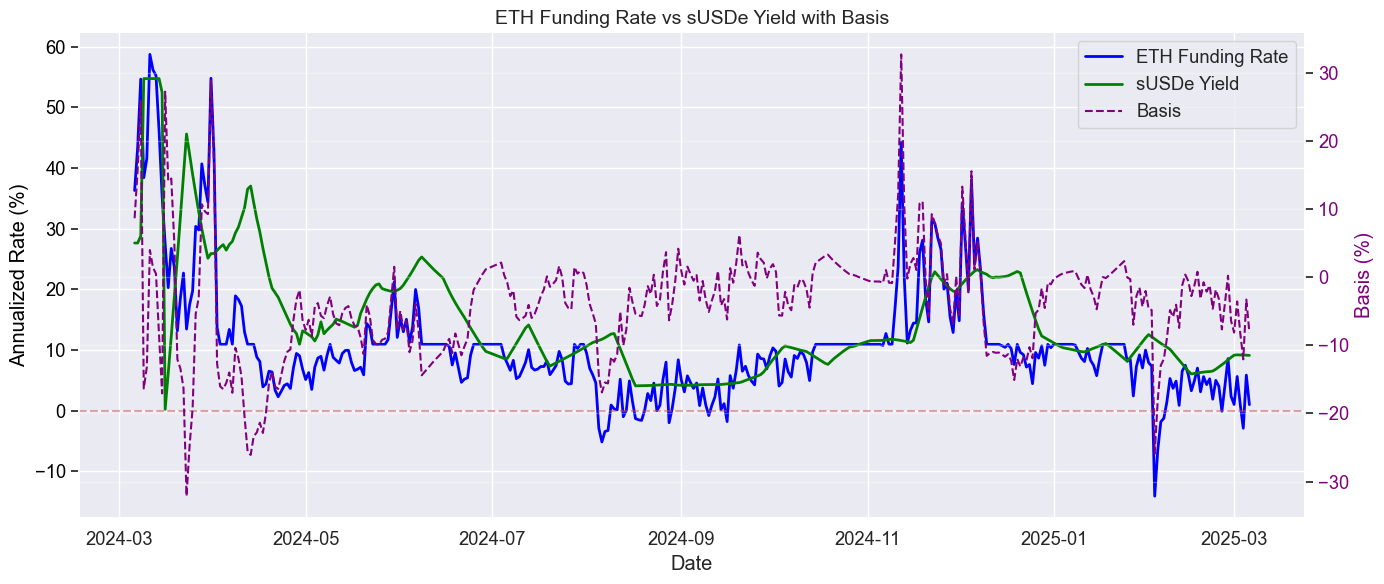


Average ETH Funding Rate: 10.8052%
Average sUSDe Yield: 14.6436%
Average Basis: -3.8384%


In [2]:
#------------------------------------------------------
# Step 1: Understand and Visualize ETH Funding Rates and sUSDe Yield
#------------------------------------------------------
print("\n--- Step 1: Analyzing Funding Rate and Yield Patterns ---")
# Plot funding rate and yield over time with basis on secondary axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Primary axis - ETH funding rate and sUSDe yield
color1 = 'blue'
color2 = 'green'
ax1.plot(df['Timestamp'], df['funding_annualized_pct'], color=color1, linewidth=2, label='ETH Funding Rate')
ax1.plot(df['Timestamp'], df['sUSDe_annualized_yield'], color=color2, linewidth=2, label='sUSDe Yield')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Annualized Rate (%)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Secondary axis - Basis (difference between funding rate and yield)
ax2 = ax1.twinx()
color3 = 'purple'
# Calculate basis (ETH funding rate - sUSDe yield)
basis = df['funding_annualized_pct'] - df['sUSDe_annualized_yield']
ax2.plot(df['Timestamp'], basis, color=color3, linewidth=1.5, linestyle='--', label='Basis')
ax2.set_ylabel('Basis (%)', color=color3)
ax2.tick_params(axis='y', labelcolor=color3)

# Add legend for all lines
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('ETH Funding Rate vs sUSDe Yield with Basis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print averages
avg_eth_funding = df['funding_annualized_pct'].mean()
avg_sUSDe_yield = df['sUSDe_annualized_yield'].mean()
avg_basis = basis.mean()

print(f"\nAverage ETH Funding Rate: {avg_eth_funding:.4f}%")
print(f"Average sUSDe Yield: {avg_sUSDe_yield:.4f}%")
print(f"Average Basis: {avg_basis:.4f}%")


--- Step 2: Scatter Plot Analysis ---


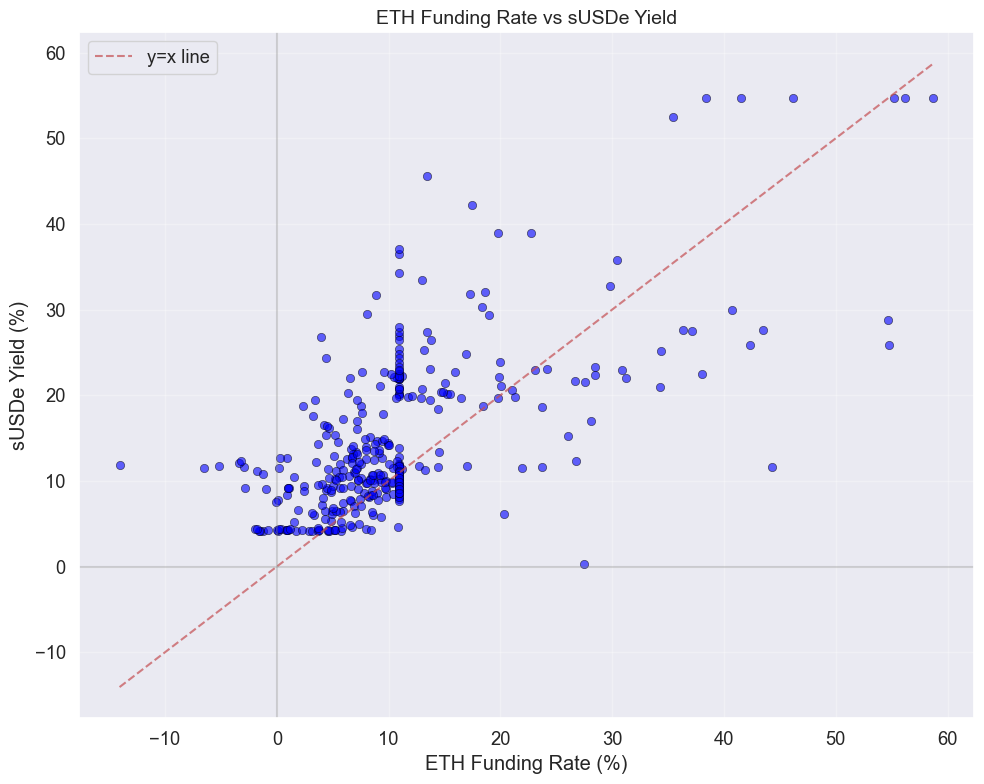


Correlation between ETH Funding Rate and sUSDe Yield: 0.6669


In [3]:
#------------------------------------------------------
# Step 2: Scatter Plot of ETH Funding Rate vs sUSDe Yield
#------------------------------------------------------
print("\n--- Step 2: Scatter Plot Analysis ---")

plt.figure(figsize=(10, 8))
plt.scatter(df['funding_annualized_pct'], df['sUSDe_annualized_yield'], 
            alpha=0.6, color='blue', edgecolor='black', linewidth=0.5)

# Add diagonal reference line (y=x)
min_val = min(df['funding_annualized_pct'].min(), df['sUSDe_annualized_yield'].min())
max_val = max(df['funding_annualized_pct'].max(), df['sUSDe_annualized_yield'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, label='y=x line')

plt.title('ETH Funding Rate vs sUSDe Yield', fontsize=14)
plt.xlabel('ETH Funding Rate (%)')
plt.ylabel('sUSDe Yield (%)')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation coefficient
correlation = df['funding_annualized_pct'].corr(df['sUSDe_annualized_yield'])
print(f"\nCorrelation between ETH Funding Rate and sUSDe Yield: {correlation:.4f}")


--- Step 3: Calculating Cumulative Basis by Market Window ---
     Market ID          Start Date Expiry Date  Data Points  Cumulative Basis  Average Basis  Average Funding  Average sUSDE Yield
0  0xd1d7d9... 2024-05-20 05:00:00  2024-09-26          129        557.269733       4.319920         6.838849            11.158770
2  0xa0ab94... 2024-07-17 06:00:00  2024-12-26          162        274.472629       1.694275         9.516379            11.210655
1  0xbbf399... 2024-07-17 14:00:00  2024-10-24           99        202.740592       2.047885         5.262658             7.310543
4  0xcdd26e... 2024-09-17 05:00:00  2025-03-27          170        282.220181       1.660119        10.434994            12.095112
5  0xb162b7... 2024-11-13 15:00:00  2025-05-29          113        354.183468       3.134367        10.436164            13.570531
3  0xd3c295... 2024-12-10 13:00:00  2025-02-27           79        357.780152       4.528863         7.352167            11.881030


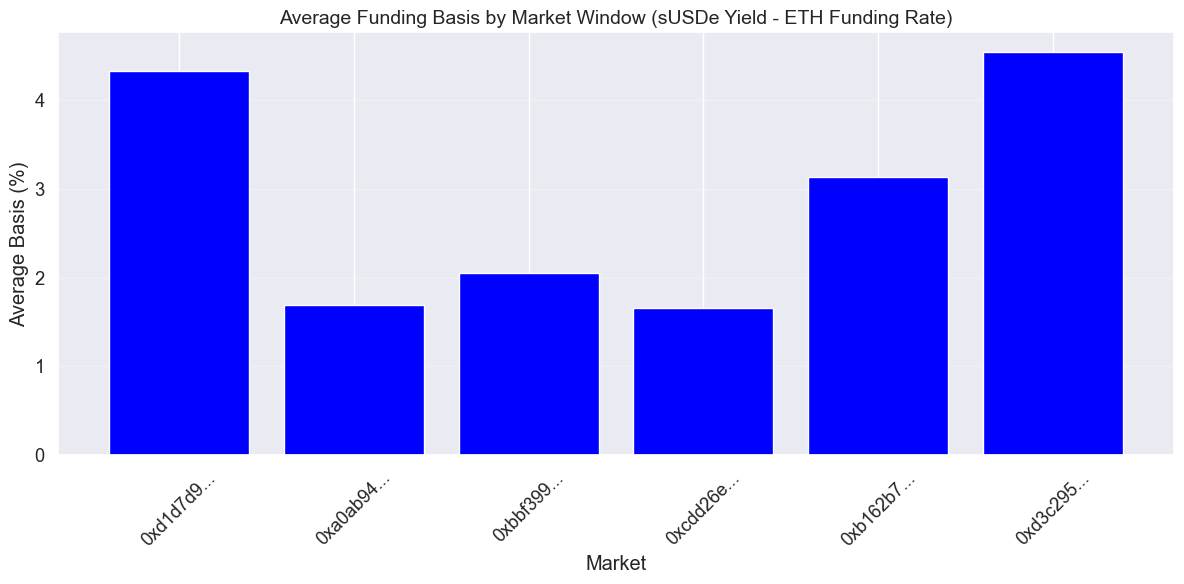

In [4]:
#------------------------------------------------------
# Step 3: Calculate Cumulative Basis for Each Market Window
#------------------------------------------------------
print("\n--- Step 3: Calculating Cumulative Basis by Market Window ---")

# Read the markets data
markets_df = pd.read_csv("../binance_data_pipeline/data/markets/sUSDe_Markets.csv")

# Convert date strings to datetime objects
markets_df['first_data'] = pd.to_datetime(markets_df['first_data'])
markets_df['expiry'] = pd.to_datetime(markets_df['expiry'])

# Ensure the main dataframe timestamp is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Calculate inverted basis (sUSDe yield - funding rate)
df['basis'] = df['sUSDe_annualized_yield'] - df['funding_annualized_pct']

# Create a dataframe to store results
results = []

# Process each market window
for _, market in markets_df.iterrows():
    # Filter data for this market's time window
    mask = (df['Timestamp'] >= market['first_data']) & (df['Timestamp'] <= market['expiry'])
    market_data = df[mask]
    
    if len(market_data) > 0:
        # Calculate metrics for this window
        cum_basis = market_data['basis'].sum()
        avg_basis = market_data['basis'].mean()
        avg_funding = market_data['funding_annualized_pct'].mean()
        avg_yield = market_data['sUSDe_annualized_yield'].mean()
        data_points = len(market_data)
        
        # Create a shorter market ID for display
        short_id = market['market_id'].split('-')[1][:8] + '...'
        
        # Store results
        results.append({
            'Market ID': short_id,
            'Full Market ID': market['market_id'],
            'Start Date': market['first_data'],
            'Expiry Date': market['expiry'],
            'Data Points': data_points,
            'Cumulative Basis': cum_basis,
            'Average Basis': avg_basis,
            'Average Funding': avg_funding,
            'Average sUSDE Yield': avg_yield
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

# Sort by start date
results_df = results_df.sort_values('Start Date')

# Display results
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_df[['Market ID', 'Start Date', 'Expiry Date', 'Data Points', 
                 'Cumulative Basis', 'Average Basis', 'Average Funding', 'Average sUSDE Yield']])


# Also plot average basis by market
plt.figure(figsize=(12, 6))
plt.bar(results_df['Market ID'], results_df['Average Basis'], color='blue')
plt.title('Average Funding Basis by Market Window (sUSDe Yield - ETH Funding Rate)', fontsize=14)
plt.xlabel('Market')
plt.ylabel('Average Basis (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


--- Visualizing Implied APY by Market ---


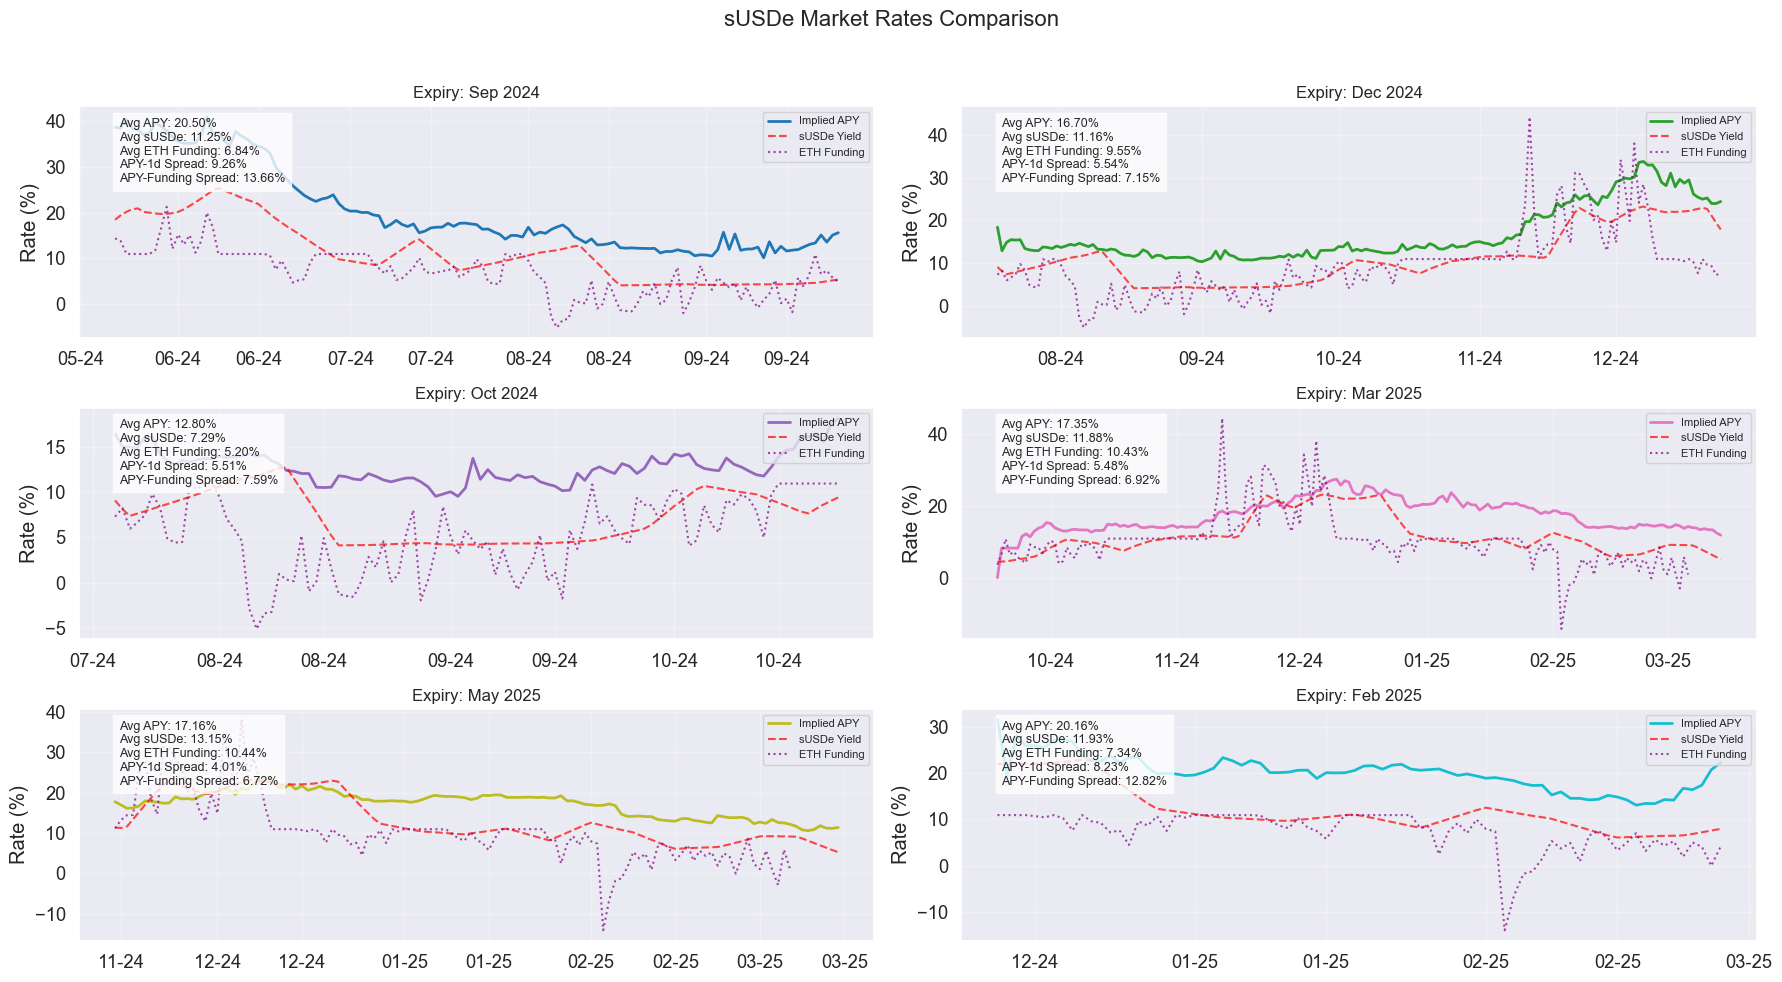

In [8]:
#------------------------------------------------------
# Visualize Implied APY for All Markets
#------------------------------------------------------
print("\n--- Visualizing Implied APY by Market ---")

# Read the data
iy_df = pd.read_csv("../binance_data_pipeline/data/markets/sUSDe_IY_markets_history.csv")

# Convert timestamp to datetime
iy_df['timestamp'] = pd.to_datetime(iy_df['timestamp'])

# Read the 1d yield history data
sUSDe_yield_df = pd.read_csv("../binance_data_pipeline/data/markets/sUSDe_1d_yield_history.csv")
sUSDe_yield_df['timestamp'] = pd.to_datetime(sUSDe_yield_df['timestamp'])

markets_df = pd.read_csv('../binance_data_pipeline/data/markets/sUSDe_Markets.csv')
markets_df['expiry'] = pd.to_datetime(markets_df['expiry'])

# Create a mapping from market_id to expiry date
market_expiry = dict(zip(markets_df['market_id'], markets_df['expiry']))

# Get unique market IDs
market_ids = iy_df['market_id'].unique()

# Create a color map for consistent colors across markets
colors = plt.cm.tab10(np.linspace(0, 1, len(market_ids)))
color_map = dict(zip(market_ids, colors))

# Create individual charts for each market
plt.figure(figsize=(18, 10))

# Calculate number of rows and columns for the subplot grid
n_markets = len(market_ids)
n_cols = 2
n_rows = (n_markets + 1) // n_cols

# Import the date formatter
from matplotlib.dates import DateFormatter

for i, mid in enumerate(market_ids):
    ax = plt.subplot(n_rows, n_cols, i+1)
    
    # Plot the market implied APY
    market_data = iy_df[iy_df['market_id'] == mid]
    ax.plot(market_data['timestamp'], 
            market_data['implied_apy'] * 100,
            color=color_map[mid],
            linewidth=2,
            label='Implied APY')
    
    # Get market date range for filtering 1d yield data and funding rate
    first_date = market_data['timestamp'].min()
    last_date = market_data['timestamp'].max()
    
    # Filter 1d yield data for this market's date range
    yield_data = sUSDe_yield_df[(sUSDe_yield_df['timestamp'] >= first_date) & 
                                (sUSDe_yield_df['timestamp'] <= last_date)]
    
    # Plot 1d yield if available
    avg_1d_yield = None
    if not yield_data.empty:
        ax.plot(yield_data['timestamp'], 
                yield_data['avg_1d'] * 100,  # Convert to percentage
                color='red',
                linestyle='--',
                linewidth=1.5,
                alpha=0.7,
                label='sUSDe Yield')
        
        # Calculate average sUSDe for this period
        avg_1d_yield = yield_data['avg_1d'].mean() * 100
    
    # Filter funding rate data for this market's date range
    funding_data = df[(df['Timestamp'] >= first_date) & (df['Timestamp'] <= last_date)]
    
    # Plot funding rate if available
    avg_funding = None
    if not funding_data.empty:
        ax.plot(funding_data['Timestamp'], 
                funding_data['funding_annualized_pct'],
                color='purple',
                linestyle=':',
                linewidth=1.5,
                alpha=0.7,
                label='ETH Funding')
        
        # Calculate average funding rate for this period
        avg_funding = funding_data['funding_annualized_pct'].mean()
    
    # Get market details for better labeling
    avg_apy = market_data['implied_apy'].mean() * 100
    
    # Format the x-axis to show mm-yy
    date_format = DateFormatter('%m-%y')
    ax.xaxis.set_major_formatter(date_format)
    
    # Get expiry date for title
    expiry_date = market_expiry.get(mid)
    if expiry_date:
        expiry_str = expiry_date.strftime('%b %Y')  # Format as 'Mar 2025'
        ax.set_title(f"Expiry: {expiry_str}", fontsize=12)
    else:
        ax.set_title(f"Market: {mid[-6:]}", fontsize=12)
    
    ax.set_ylabel('Rate (%)')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(loc='upper right', fontsize=8)
    
    # Add average rates text
    text_info = f"Avg APY: {avg_apy:.2f}%"
    
    if avg_1d_yield is not None:
        text_info += f"\nAvg sUSDe: {avg_1d_yield:.2f}%"
    
    if avg_funding is not None:
        text_info += f"\nAvg ETH Funding: {avg_funding:.2f}%"
    
    # Calculate spreads if we have both APY and sUSDe
    if avg_1d_yield is not None and avg_apy > 0 and avg_1d_yield > 0:
        spread = avg_apy - avg_1d_yield
        text_info += f"\nAPY-1d Spread: {spread:.2f}%"
    
    # Calculate APY vs Funding spread if both available
    if avg_funding is not None and avg_apy > 0:
        funding_spread = avg_apy - avg_funding
        text_info += f"\nAPY-Funding Spread: {funding_spread:.2f}%"
    
    ax.text(0.05, 0.95, text_info, 
            transform=ax.transAxes, 
            fontsize=9,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('sUSDe Market Rates Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the main title
plt.show()